In [188]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

#Data Explore
from lifetimes.plotting import *
from lifetimes.utils import *
#from lifetimes.estimation import *

#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix

from lifetimes.plotting import plot_probability_alive_matrix

from lifetimes.plotting import plot_period_transactions

from lifetimes.utils import calibration_and_holdout_data

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

from lifetimes.plotting import plot_history_alive

from lifetimes import GammaGammaFitter


CLTV exercise

https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f

Online Retail data from http://archive.ics.uci.edu/ml/datasets/online+retail

In [189]:
df = pd.read_csv("Online Retail.csv")


In [190]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [191]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [192]:
df.shape

(541909, 8)

In [193]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [194]:
df['CustomerID'].value_counts()

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
14351.0       1
13256.0       1
12943.0       1
17923.0       1
13747.0       1
Name: CustomerID, Length: 4372, dtype: int64

# Clean the Data

## Convert date time columns

In [195]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


## Remove null values from key columns

In [196]:
df = df[pd.notnull(df['CustomerID'])]


In [197]:
df = df[(df['Quantity']>0)]


## Feature Engineering
### Create Sales columns

In [198]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [199]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


## Create dataframe you plan on using

In [200]:
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]
df.head()

,CustomerID,InvoiceDate,Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [201]:
df['CustomerID'].nunique()

4339

# CLV Model Definition
For the CLV models, the following nomenclature is used:
* **Frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
* **T** represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
* **Recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

The following analysis is conducted in Python using Lifetimes packagedeveloped by Cameron Davidson-Pilon, data scientist at Shopify, and the code was largely borrowed from Lifetimes documentation.

In [202]:
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


https://lifetimes.readthedocs.io/en/latest/lifetimes.html?highlight=summary_data_from_transaction_data#lifetimes.utils.summary_data_from_transaction_data

In [203]:
data.sort_values('monetary_value', ascending=False)

,frequency,recency,T,monetary_value
CustomerID,,,,
16446.0,1.0,205.0,205.0,168469.6000
15749.0,1.0,97.0,332.0,21535.9000
18102.0,25.0,367.0,367.0,9349.4772
12536.0,1.0,16.0,59.0,8322.1200
12415.0,15.0,313.0,337.0,7860.2100
...,...,...,...,...
15147.0,0.0,0.0,240.0,0.0000
15148.0,0.0,0.0,10.0,0.0000
15149.0,0.0,0.0,133.0,0.0000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
One time purchasers as a percent:  0.3569946992394561


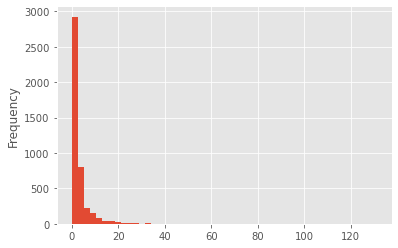

In [204]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(f'One time purchasers as a percent: ',sum(data['frequency'] == 0)/float(len(data)))

Among all customers in our data, more than 35% of them only made purchase once (no repeat).

## Frequency/Recency Analysis Using the BG/NBD Model

In [205]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

Consider: a customer has made purchase every day for four weeks straight, and then we haven’t heard from him in months. What are the chances he is still “alive”? Pretty small, right? On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given his recency (age at last purchase) and frequency (the number of repeat transactions he has made).

## Expected Number of Future Purchases for 1 Unit of Time

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

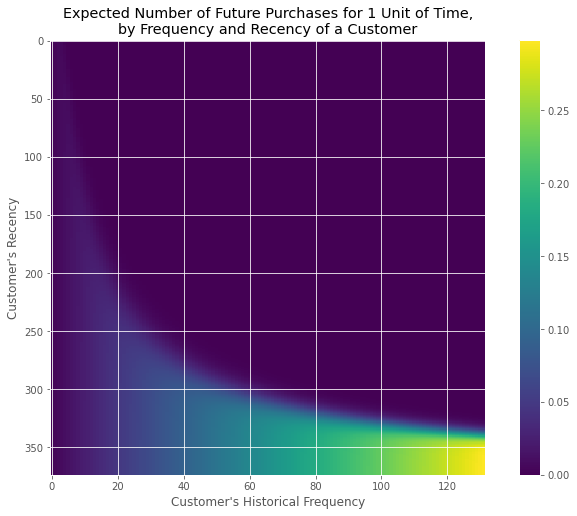

In [206]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

* Bottom-righ: Best customer 120 purchases 350 days ago

* Top-right: Customers who have purchased a lot but not recently (top-right corner), have probably gone.

* Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them.

* Bottom middle: around (40, 300) that represents the customer who buys infrequently, and we have not seen him recently, so he might buy again. However, we are not sure if he has gone or just between purchases.

## Predicting which customers will come alive

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

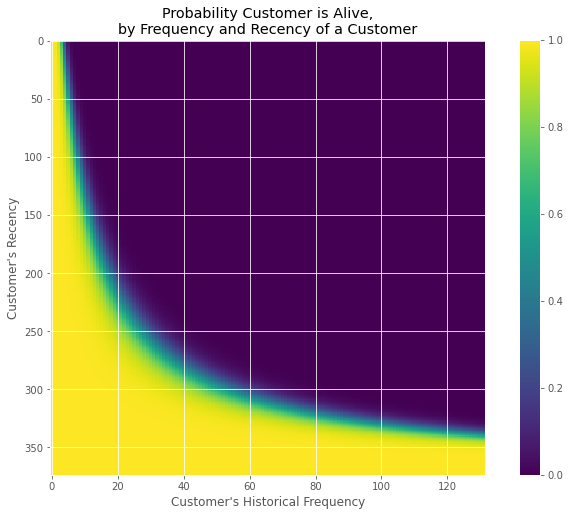

In [207]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

Customers who have purchased recently are almost surely “alive”.

Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

We are ranking customers from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [208]:
data.columns

Index(['frequency', 'recency', 'T', 'monetary_value'], dtype='object')

In [209]:
t = 1
data['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])

data.sort_values(by='predicted_purchase').tail(5)

,frequency,recency,T,monetary_value,predicted_purchase
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


## Assessing model fit

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

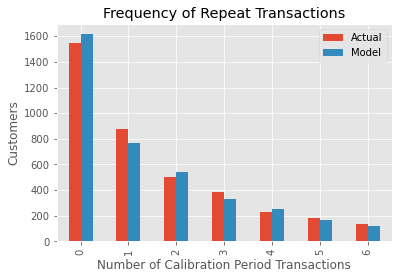

In [210]:
plot_period_transactions(bgf)

Model looks close to Actual.  Continue to move forward

## Partition calibration period and holdout dataset

In [211]:
summary_cal_holdout = calibration_and_holdout_data(df, "CustomerID", 'InvoiceDate', calibration_period_end='2011-06-08', observation_period_end='2011-12-9')

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0
12348.0,2.0,110.0,174.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
12352.0,3.0,34.0,112.0,3.0,184.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

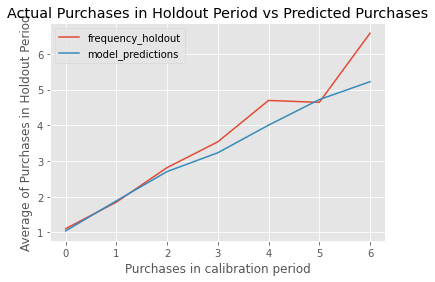

In [212]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## Customer transactions predictions

In [213]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15727743137863798

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

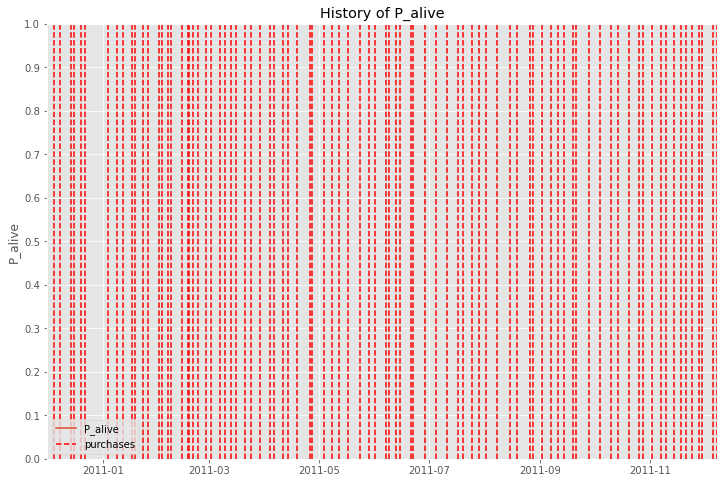

In [214]:
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth =365
sp_trans = df.loc[df['CustomerID'] ==id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [215]:
df['CustomerID'].value_counts()

17841.0    7847
14911.0    5677
14096.0    5111
12748.0    4596
14606.0    2700
           ... 
17763.0       1
14576.0       1
15657.0       1
13256.0       1
13120.0       1
Name: CustomerID, Length: 4339, dtype: int64

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

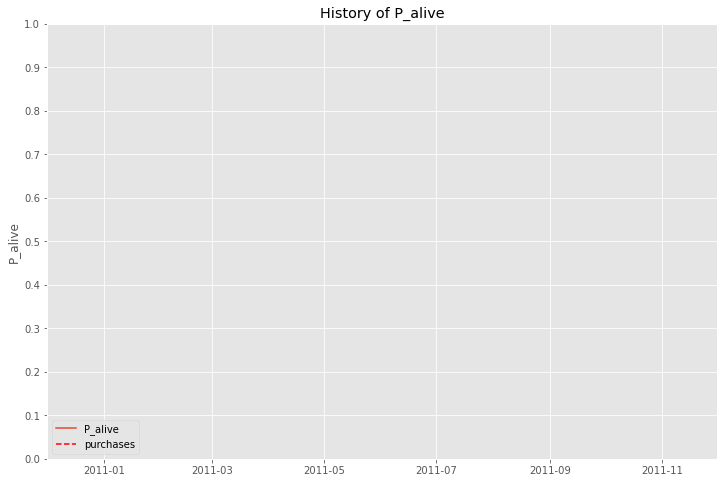

In [216]:
fig = plt.figure(figsize=(12,8))
id = 14729
days_since_bith = 365
sp_trans=df.loc[df['CustomerID'] ==id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

# Estimating customer lifetime value using gamma-gamma model of monetary value

In [217]:
returning_customers_summary = data[data['frequency']>0]

print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchase
CustomerID                                                               
12347.0           6.0    365.0  367.0      599.701667            0.015656
12348.0           3.0    283.0  358.0      301.480000            0.008956
12352.0           6.0    260.0  296.0      368.256667            0.018697
12356.0           2.0    303.0  325.0      269.905000            0.007172
12358.0           1.0    149.0  150.0      683.200000            0.008340
2790


In [218]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'], returning_customers_summary['monetary_value'])
ggf

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

## After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. Phew!

In [219]:
est_avg_val = ggf.conditional_expected_average_profit(data['frequency'], data['monetary_value'])
est_avg_val.head(10)

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64

In [220]:
est_avg_val.describe()

count     4339.000000
mean       441.128403
std       1229.939881
min         47.048956
25%        312.401730
50%        416.917667
75%        416.917667
max      78051.285456
dtype: float64